# Methodology for state identification of time series based on Random Forest

## First Initializations

Import libraries:

In [1]:
import sys
sys.path.append("../")
sys.path.append("../src/")
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from read_dataset import read_datasets
%matplotlib inline

For repetibility init random state:

In [2]:
random_state = 123

## Identification of best families and parameters:

Load results of optimizer_parameters.py:

In [3]:
with open('../data/DB_002V0_ooberror15062017.pickle', 'rb') as f:
    optimizer = pickle.load(f)

Search of best subset families and plot of each parameters space:

(0,) (14, 58) 0.0454545454545
(1,) (8, 561) 0.05
(2,) (39, 69) 0.0409090909091
(3,) (40, 20) 0.0409090909091
(4,) (14, 74) 0.0409090909091
(0, 1) (64, 41) 0.0454545454545
(0, 2) (44, 52) 0.0454545454545
(0, 3) (24, 43) 0.0409090909091
(0, 4) (13, 403) 0.05
(1, 2) (21, 35) 0.0409090909091
(1, 3) (67, 9) 0.0409090909091


/home/dcabrera/myvenv/lib64/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(1, 4) (14, 598) 0.0454545454545
(2, 3) (16, 241) 0.0409090909091
(2, 4) (16, 255) 0.0409090909091
(3, 4) (10, 40) 0.0454545454545
(0, 1, 2) (48, 22) 0.0409090909091
(0, 1, 3) (61, 64) 0.0409090909091
(0, 1, 4) (10, 984) 0.0454545454545
(0, 2, 3) (25, 82) 0.0363636363636
(0, 2, 4) (12, 405) 0.0454545454545
(0, 3, 4) (16, 62) 0.0409090909091
(1, 2, 3) (25, 53) 0.0409090909091
(1, 2, 4) (66, 168) 0.0409090909091
(1, 3, 4) (16, 25) 0.0409090909091
(2, 3, 4) (16, 56) 0.0363636363636
(0, 1, 2, 3) (125, 62) 0.0363636363636
(0, 1, 2, 4) (63, 173) 0.0409090909091
(0, 1, 3, 4) (56, 34) 0.0363636363636
(0, 2, 3, 4) (93, 33) 0.0363636363636
(1, 2, 3, 4) (16, 62) 0.0409090909091
(0, 1, 2, 3, 4) (60, 20) 0.0363636363636


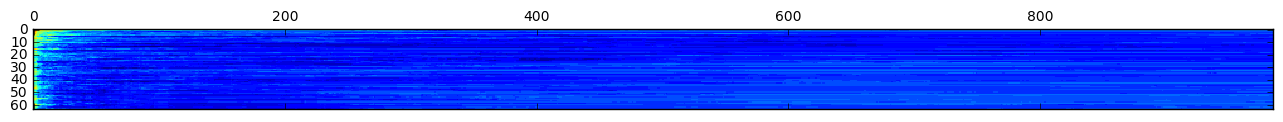

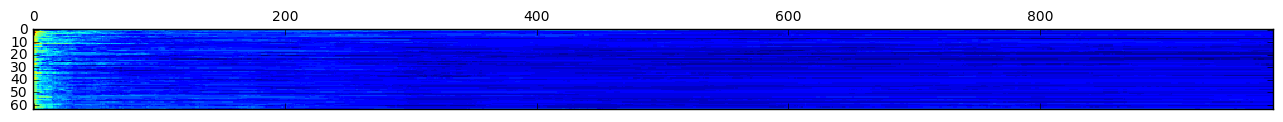

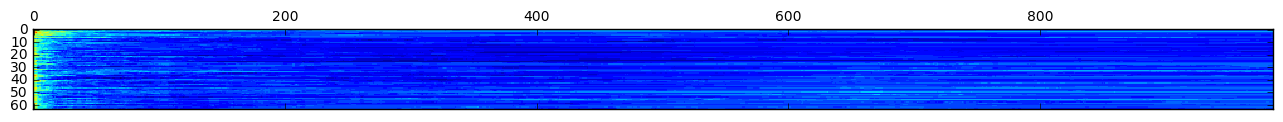

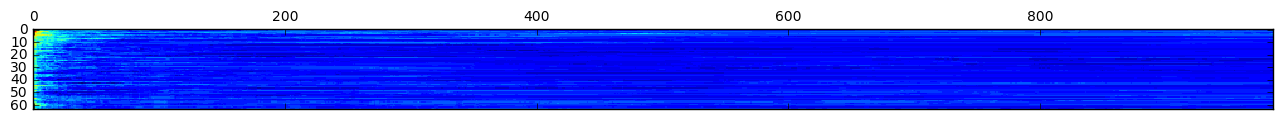

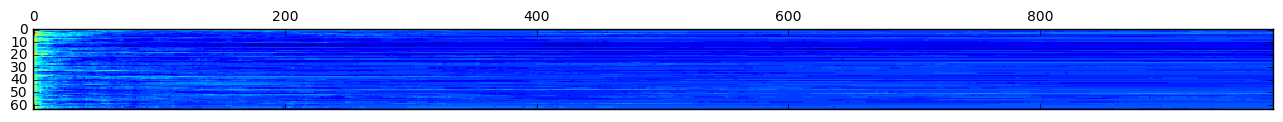

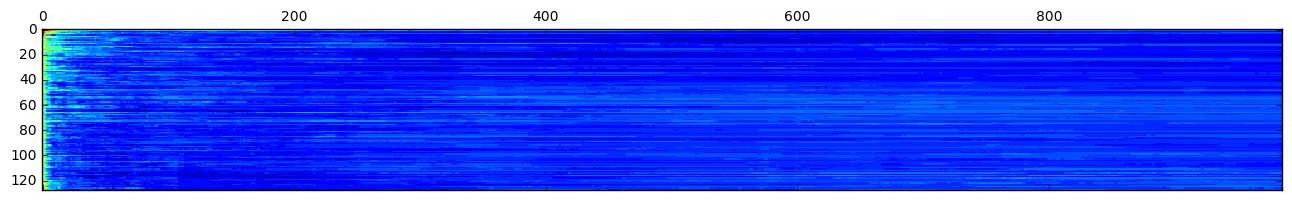

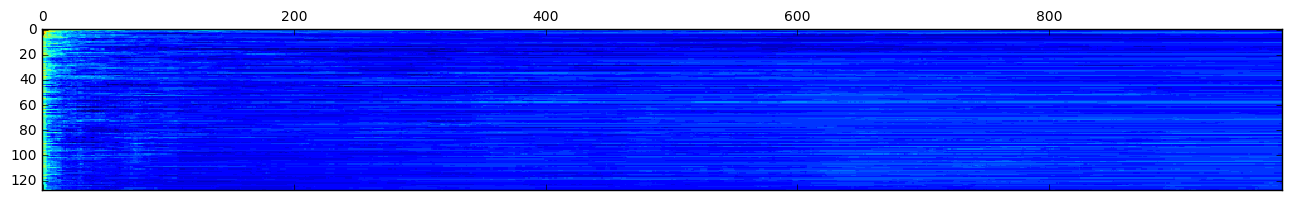

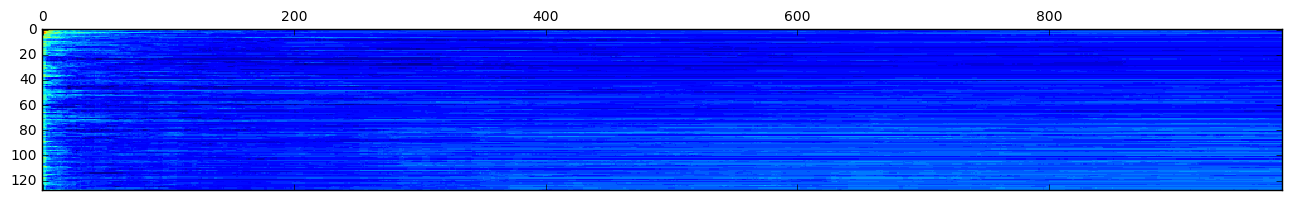

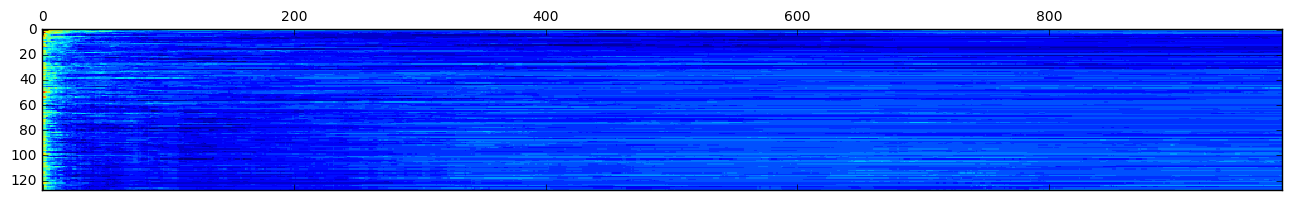

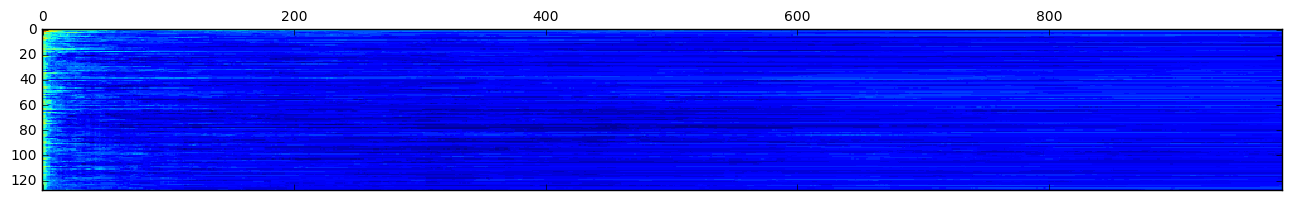

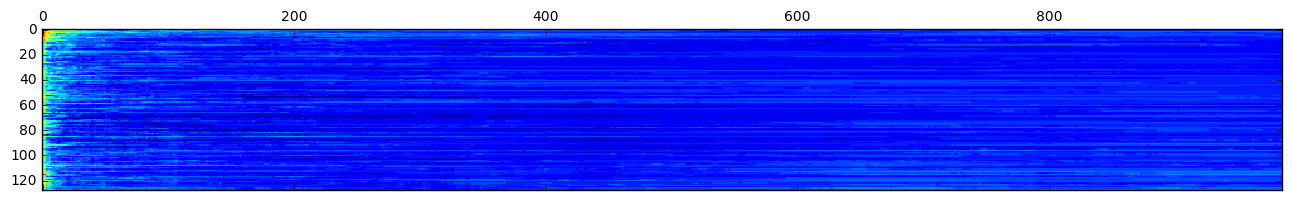

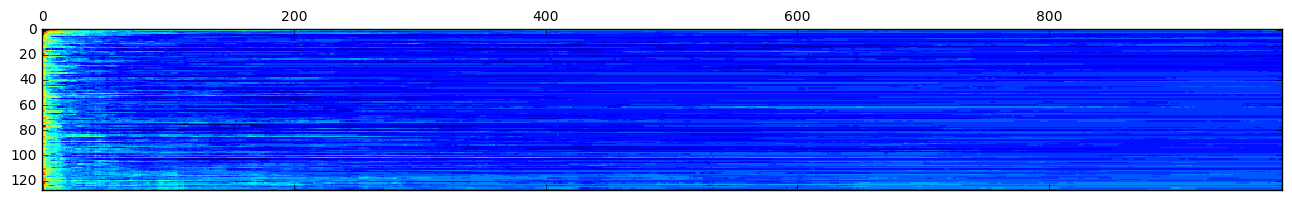

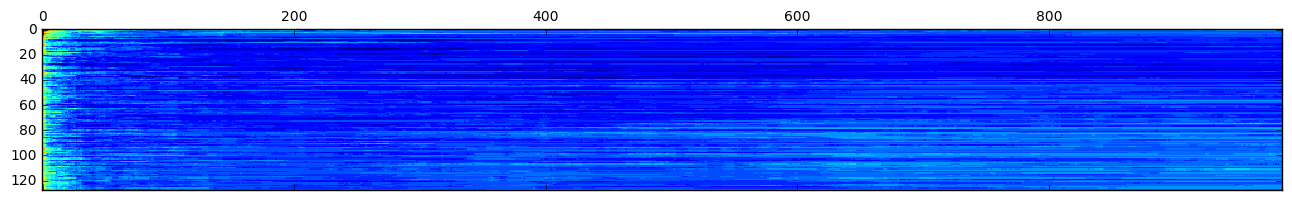

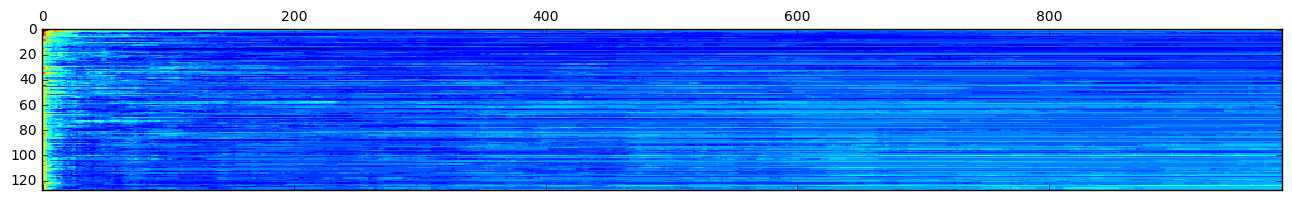

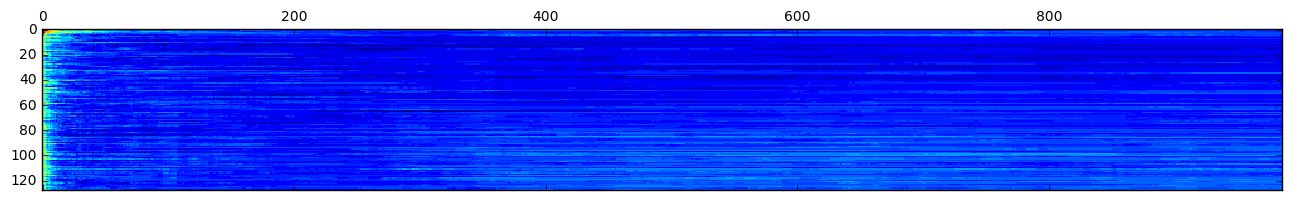

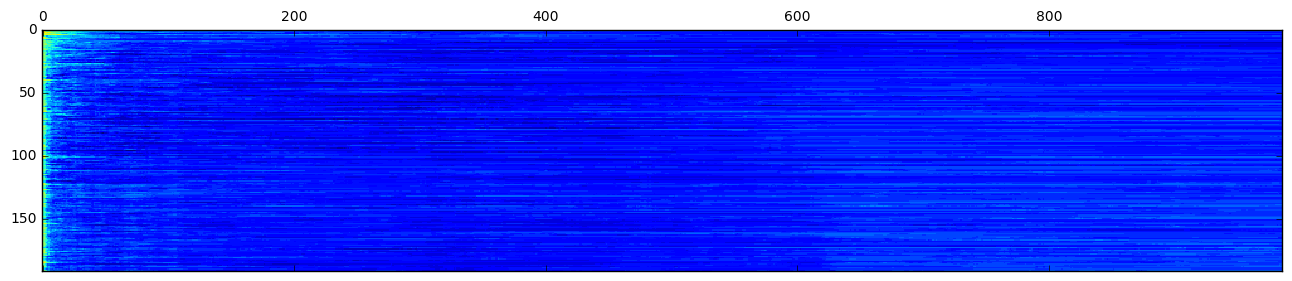

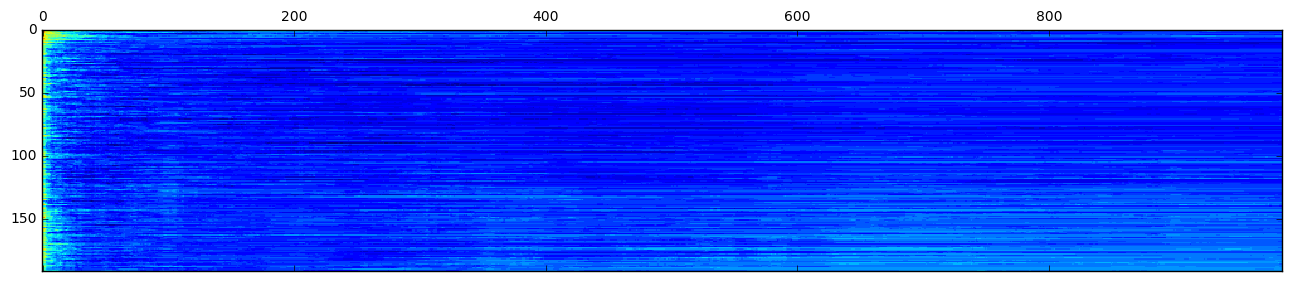

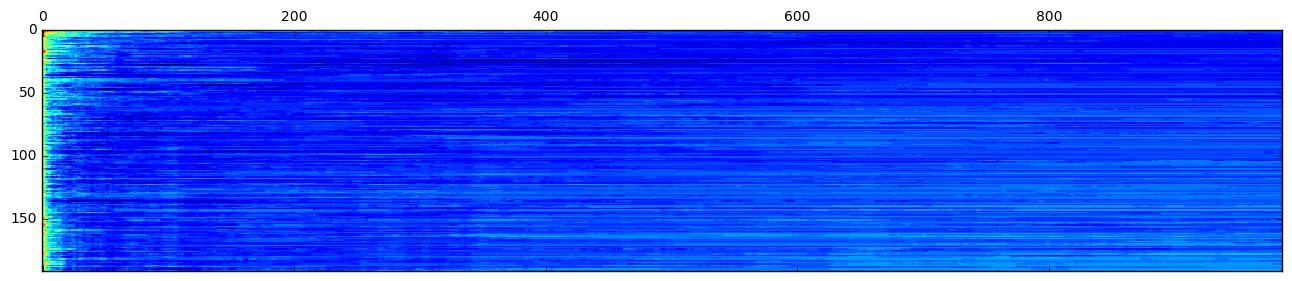

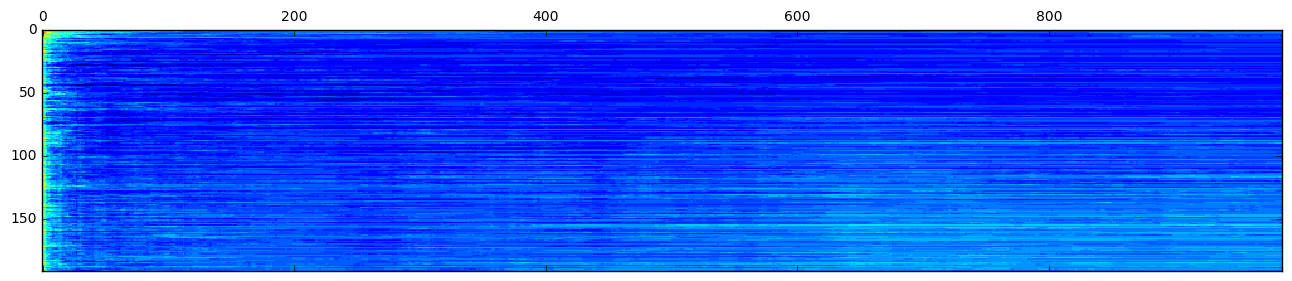

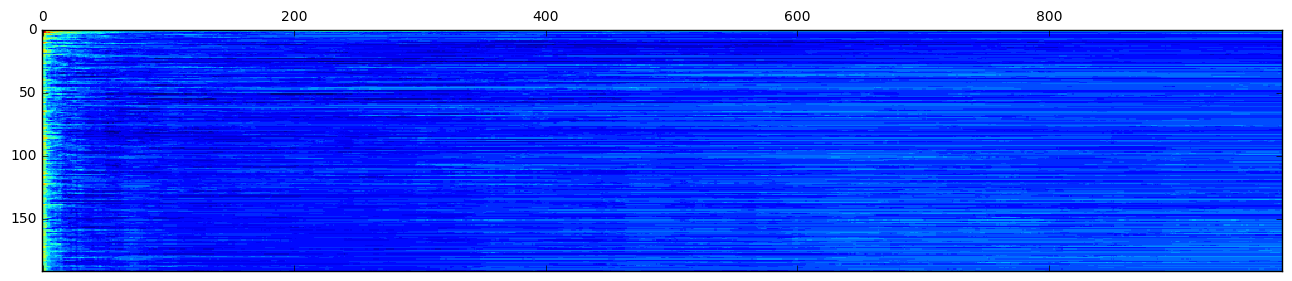

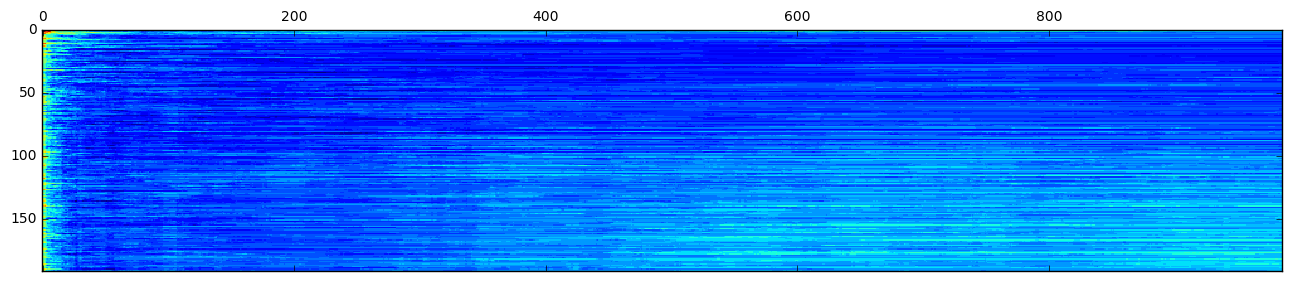

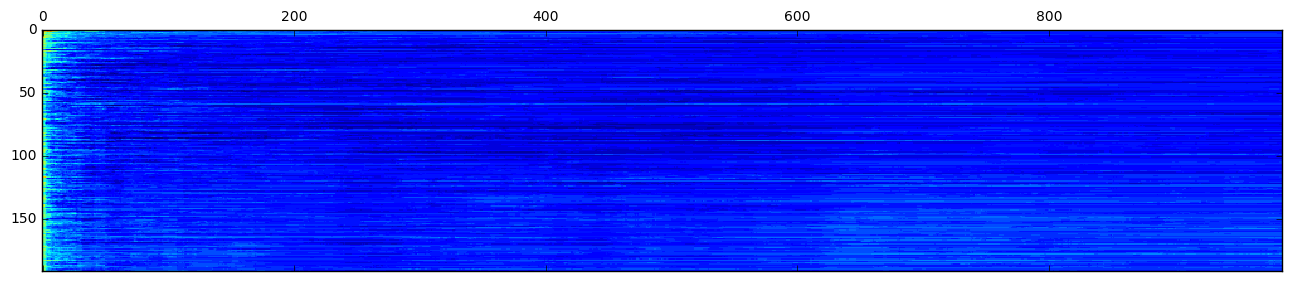

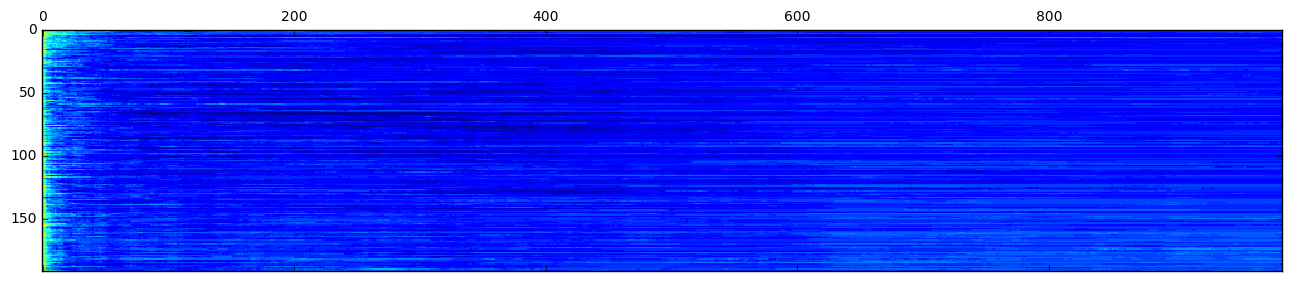

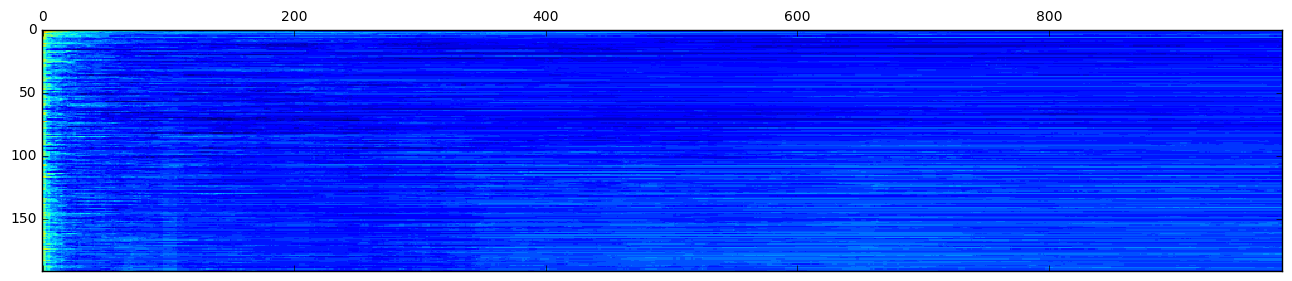

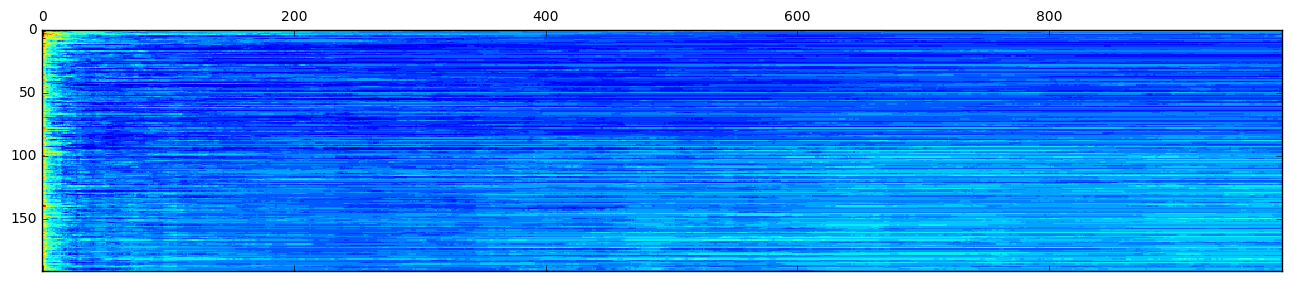

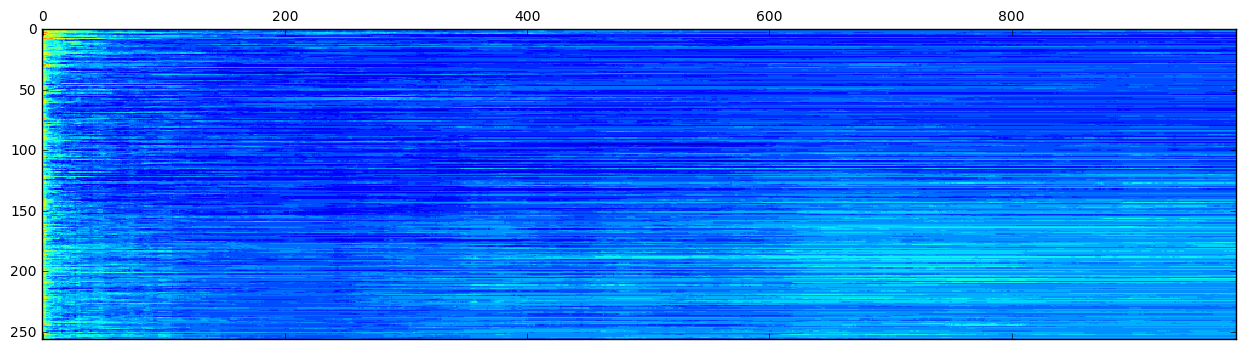

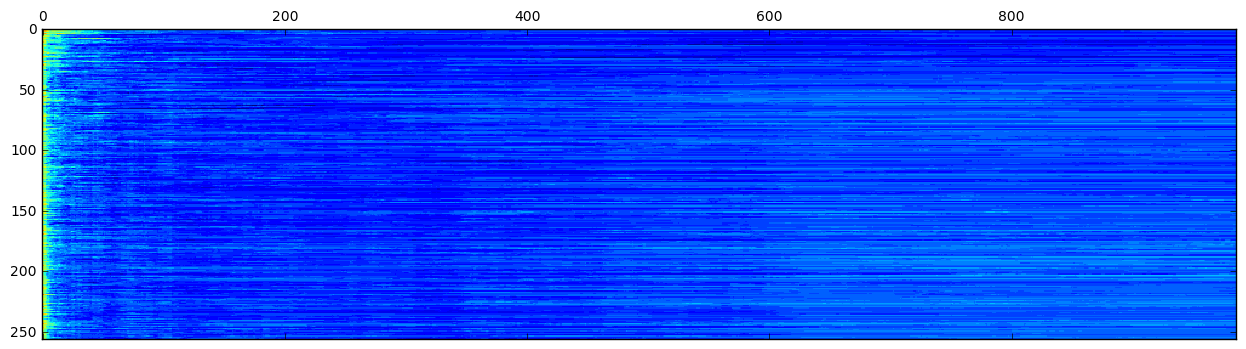

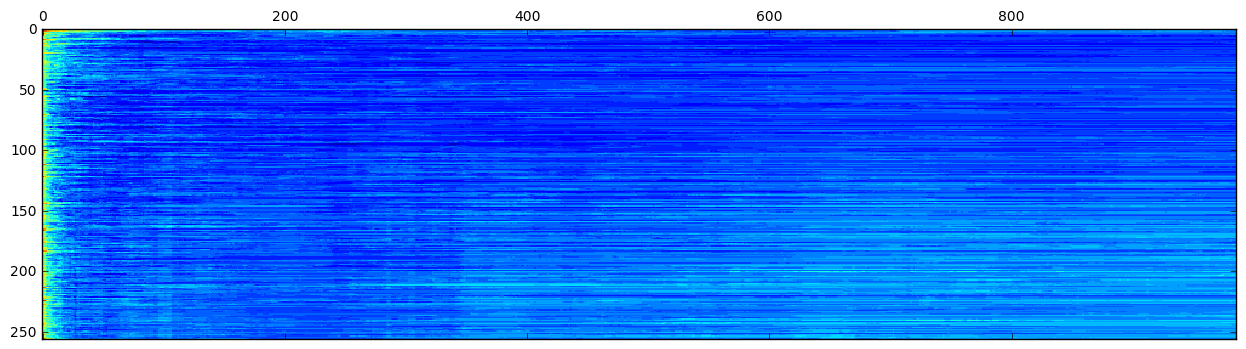

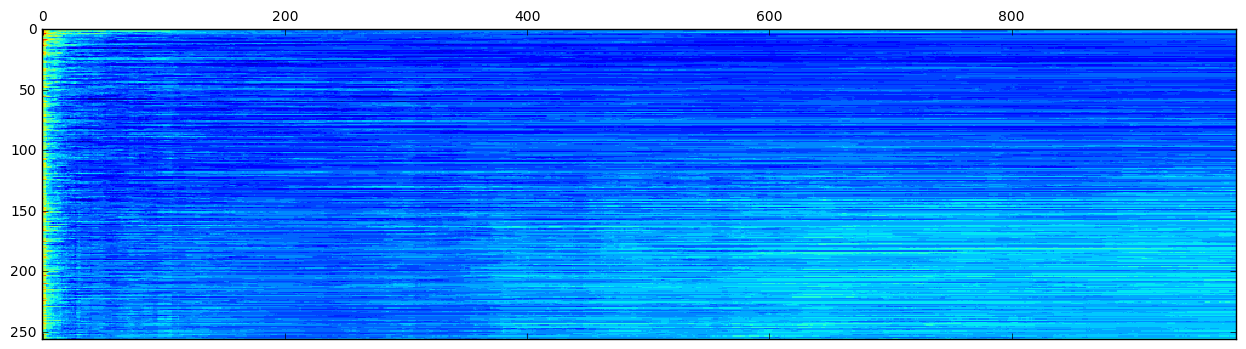

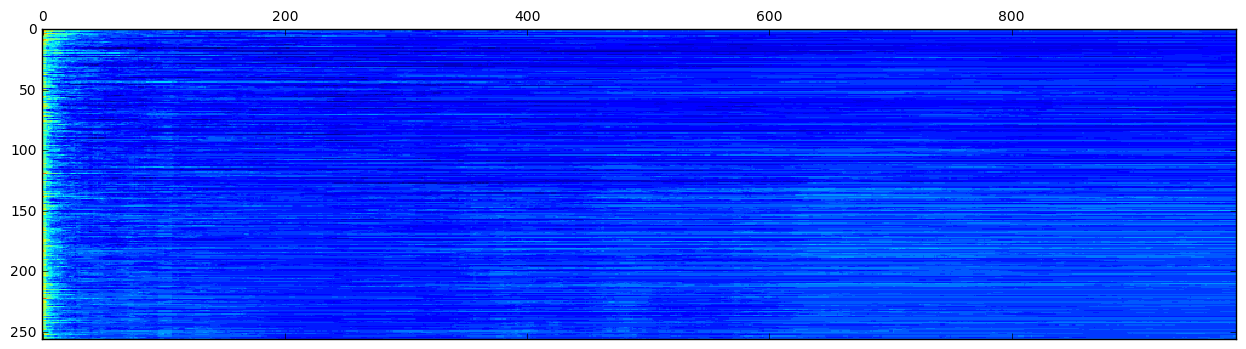

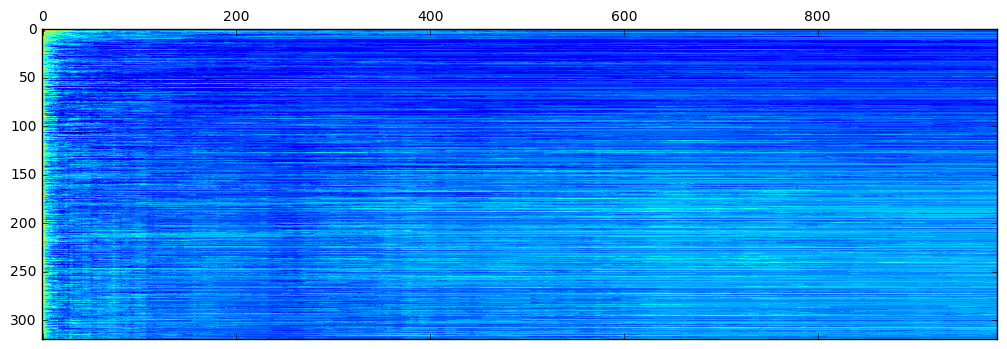

In [4]:
error_family = []
for i, subset in enumerate(optimizer.subsets_families):
    oob_errors = optimizer.oob_errors[i]
    index = np.unravel_index(np.argmin(oob_errors), oob_errors.shape)
    error_family.append(oob_errors[index])
    print(subset, index, oob_errors[index])
    plt.figure()
    plt.matshow(oob_errors)

Identification of best subset families and parameters:

In [11]:
np.where(np.array(error_family) == np.array(error_family).min())[0][1]

24

In [12]:
selected_min = np.where(np.array(error_family) == np.array(error_family).min())[0][1]
subset_family = optimizer.subsets_families[selected_min]
oob_errors = optimizer.oob_errors[np.argmin(error_family)]
index = np.unravel_index(np.argmin(oob_errors), oob_errors.shape)
print('subset_family:',subset_family)
print('random_features:',index[0])
print('n_trees:',index[1])

subset_family: (2, 3, 4)
random_features: 25
n_trees: 82


## Feature Selection with Random Forest

Load of best families:

In [13]:
starts = np.array(subset_family)*2**optimizer.max_level
optimizer.features_index[:] = False
for start in starts:
    optimizer.features_index[start:start+2**optimizer.max_level] = True

Obtain feature importance with parameters selected:

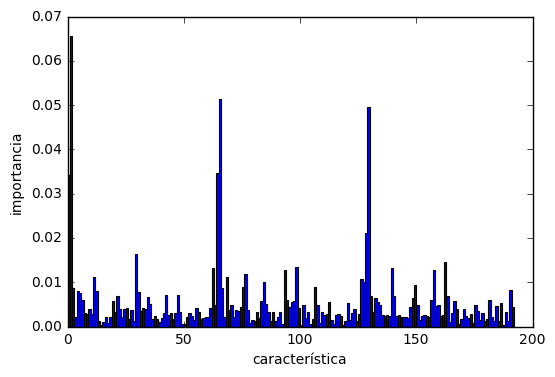

In [52]:
optimizer.model.set_params(max_features=index[0])
optimizer.model.set_params(n_estimators=index[1])
optimizer.model.set_params(warm_start=False)
optimizer.model.set_params()
optimizer.model.fit(optimizer.dataset.data[:, optimizer.features_index], optimizer.dataset.labels[:,-1])
importances = optimizer.model.feature_importances_
plt.bar(range(len(importances)),importances,linewidth=0.8,width=1)
plt.xlabel('característica')
plt.ylabel('importancia')
plt.savefig('images/feature_importances_DB002V0.pdf')

Filtering by importance:

In [43]:
train_selected_family = optimizer.dataset.data[:, optimizer.features_index]
train_selected_features = train_selected_family[:, importances > 0.003]
train_labels = optimizer.dataset.labels[:,-1]

## Build of final model

In [44]:
final_model = RandomForestClassifier(oob_score=True, random_state=random_state)
final_model.set_params(max_features=index[0])
final_model.set_params(n_estimators=index[1])
final_model.fit(train_selected_features, train_labels)
print('final oob_error:',1 - final_model.oob_score_)

final oob_error: 0.0545454545455


## Test of final model

Load test data:

In [38]:
path = '../data/features002V0.pickle'
dataset, _, _ = read_datasets(path, random_state)
dataset = dataset.test
test_selected_family = dataset.data[:, optimizer.features_index]
test_selected_features = test_selected_family[:, importances > 0.005]
test_labels = dataset.labels[:,-1]

number of instances: 315
number of features: 320


Compute metrics and confusion matrix:

In [39]:
pred_labels = final_model.predict(test_selected_features)
print(classification_report(test_labels, pred_labels))
print(confusion_matrix(test_labels,pred_labels))

             precision    recall  f1-score   support

          1       0.93      1.00      0.97        14
          2       0.93      1.00      0.96        13
          3       0.82      1.00      0.90        14
          4       1.00      0.92      0.96        13
          5       0.87      1.00      0.93        13
          6       1.00      0.86      0.92        14
          7       1.00      0.71      0.83        14

avg / total       0.94      0.93      0.92        95

[[14  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0]
 [ 0  0 14  0  0  0  0]
 [ 0  1  0 12  0  0  0]
 [ 0  0  0  0 13  0  0]
 [ 0  0  0  0  2 12  0]
 [ 1  0  3  0  0  0 10]]
